In [2]:
#@hidden_cell

from IPython.core.display import HTML
from IPython.display import display
tag = HTML('''
<style>
    /*TU color table */
    :root {
      --tu-black:        rgb(0,0,0);
      --tu-white:        rgb(255,255,255);
      --tu-cyan:         rgb(0,166,214);
      --tu-green:        rgb(165,202,26);
      --tu-yellow:       rgb(225,196,0);
      --tu-orange:       rgb(230,70,22);
      --tu-red:          rgb(225,26,26);
      --tu-purple:       rgb(109,23,127);
      --tu-slategreen:   rgb(107,134,137);
      --tu-turqoise:     rgb(0,136,145);
      --tu-darkblue:     rgb(29,28,115);
      --tu-skyblue:      rgb(110,187,213);
    }
    h2, h3, h4 {
        background-color: var(--tu-white);
        color: var(--tu-black);
    }
    h1 {
        background-color: var(--tu-black);
        color: var(--tu-white);
    }
    em {
        color: var(--tu-cyan);
    }
     
    div.output_stdout {
        background-color: var(--tu-green);
        color: var(--tu-black);
    }
    div.output_stdout:before {
        content: "stdout output;";
    }
    div.output_stderr {
        background-color: var(--tu-yellow);
        color: var(--tu-black);
    }
    div.output_stderr:before {
        content: "stderr output;";
    }
</style>
<script>
    code_show=true; 
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    function code_toggle() {
        if (code_show){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
        code_show = !code_show
    }     
    $( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()"><h4>Notebook settings</h4></a>
''')
display(tag)

# Stock Predictor Work

Volatility in oil and gas company stocks has skyrocketed since the market crash in 2008, on the back of even more volatile oil and gas prices. Over the same period, concerns over the availability and negative environmental consequences of nonrenewable energy resources have compounded on the price volatility to elevate the opinions of critics of the oil and gas industry into a national discussion about the sustainability of the industry. As such, many states have passed policies that promote the use of alternative energy, including state Renewable Portfolio Standards (RPS), which require that a fraction of energy consumption must come from renewable energy sources, and the Production Tax Credit, a federal subsidy for wind farm production. The recent changes in our attitudes towards oil and gas companies raises the question of whether changes have introduced new risk to the value of these companies, such that it impacts the stock price of nonrenewable energy companies.

Reference 1: [Risk Factors and Value at Risk in Publicly Traded Companies of the Nonrenewable Energy Sector (January 13, 2013)](https://ssrn.com/abstract=2200526)

Reference 2: [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

Reference 3: [Time Series Prediction at IBM](https://www.youtube.com/watch?v=9qJ9hlt5h_Y)

Reference 4: [Source Notebook](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb)

## Table of Contents:
* [0 - Import Packages](#packages)
* [1 - Retreive and Handle Data](#retreival)
* [2 - Study of Correlation](#correlation)
* [3 - RNN Prediction Forecast](#rnn)
* [4 - Model Validation](#valid)

## 0 - Import Packages <a class="anchor" id="packages"></a>

Importing necessary packages

In [1]:
# machine learning packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model

# data handling
import yfinance as yf
import numpy as np
import scipy
import scipy.linalg
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# other packages
import datetime as dt
import os

/home/pcampolucci/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pcampolucci/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pcampolucci/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pcampolucci/.local/lib/python3.6/site-packages/tensorflow/python/frame

## 1 - Retreive and Handle Data <a class="anchor" id="retreival"></a>

In [2]:
# INPUT: [Company Name, Days in the Past, Intervals]

company_name = "RDS-B"
interval = "1d"
days = 5000

# get daytime and previous 7 days

currentDT = dt.datetime.now()
pastDT = currentDT - dt.timedelta(days=days)
currentDT = str(currentDT)[:10]
pastDT = str(pastDT)[:10]

company = yf.download(company_name, start=pastDT, end=currentDT, interval=interval)
euro = yf.download("EURUSD=X", start=pastDT, end=currentDT, interval=interval)
oil = yf.download("CL=F", start=pastDT, end=currentDT, interval=interval)

# build dataframe

data = pd.DataFrame()

data = data.assign(company_open = company['Open'])
data = data.assign(company_close = company['Close'])
data = data.assign(euro_open = euro['Open'])
data = data.assign(euro_close = euro['Close'])
data = data.assign(oil_open = oil['Open'])
data = data.assign(oil_close = oil['Close'])
data = data.dropna()

# add return value for each interval

data = data.assign(company_return = (company["Close"] - company["Open"]))
data = data.assign(euro_return = (euro["Close"] - euro["Open"]))
data = data.assign(oil_return = (oil["Close"] - oil["Open"]))

data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,company_open,company_close,euro_open,euro_close,oil_open,oil_close,company_return,euro_return,oil_return
Date,,,,,,,,,
2006-10-02,68.290001,67.889999,1.268006,1.274194,62.799999,61.029999,-0.400002,0.006188,-1.770000
2006-10-03,67.309998,66.750000,1.274194,1.273496,60.900002,58.680000,-0.559998,-0.000698,-2.220001
2006-10-04,66.580002,67.470001,1.273593,1.271294,58.500000,59.410000,0.889999,-0.002299,0.910000
2006-10-05,67.050003,67.209999,1.271504,1.269551,59.759998,60.029999,0.159996,-0.001953,0.270000
2006-10-06,66.540001,66.779999,1.269599,1.260398,60.040001,59.759998,0.239998,-0.009201,-0.280003
...,...,...,...,...,...,...,...,...,...
2020-06-04,33.340000,33.869999,1.123722,1.123595,36.520000,37.250000,0.529999,-0.000126,0.730000
2020-06-05,35.639999,35.990002,1.133723,1.133787,37.400002,38.970001,0.350002,0.000064,1.570000
2020-06-08,37.369999,37.650002,1.131606,1.131952,39.930000,38.590000,0.280003,0.000346,-1.340000


## 3 - Study of Correlation <a class="anchor" id="correlation"></a>

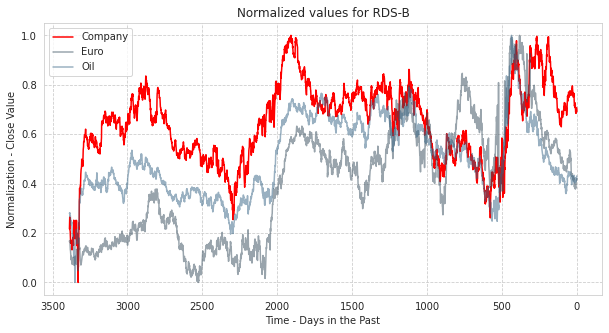

In [3]:
# plot closing value for three indicators

expl_1 = data[['company_close', 'euro_close', 'oil_close']]

expl_1 = MinMaxScaler().fit_transform(expl_1)

with sns.color_palette("Blues_d"):
    
    plt.figure(figsize=(10, 5))
    sns.set_style('whitegrid', {'grid.linestyle': '--'})
    ax = sns.lineplot(data=expl_1[:,0], alpha=1, color='r')
    ax = sns.lineplot(data=expl_1[:,1], alpha=0.5)
    ax = sns.lineplot(data=expl_1[:,2], alpha=0.5)
    ax.invert_xaxis()
    ax.set_title(f'Normalized values for {company_name}')
    ax.legend(loc='upper left', labels=['Company', 'Euro', 'Oil'])
    ax.set(xlabel='Time - Days in the Past', ylabel='Normalization - Close Value')

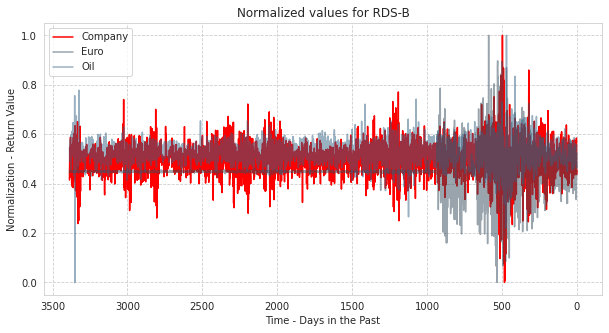

In [4]:
# plot return value for each indicator

expl_2 = data[['company_return', 'euro_return', 'oil_return']]

expl_2 = MinMaxScaler().fit_transform(expl_2)

with sns.color_palette("Blues_d"):
    
    plt.figure(figsize=(10, 5))
    sns.set_style('whitegrid', {'grid.linestyle': '--'})
    ax = sns.lineplot(data=expl_2[:,0], alpha=1, color='r')
    ax = sns.lineplot(data=expl_2[:,1], alpha=0.5)
    ax = sns.lineplot(data=expl_2[:,2], alpha=0.5)
    ax.invert_xaxis()
    ax.set_title(f'Normalized values for {company_name}')
    ax.legend(loc='upper left', labels=['Company', 'Euro', 'Oil'])
    ax.set(xlabel='Time - Days in the Past', ylabel='Normalization - Return Value')

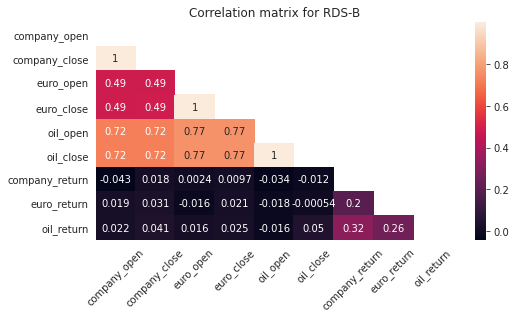

In [5]:
# Build correlation matrix for all gathered values

corr = data[['company_open', 'company_close', 'euro_open', 'euro_close', 'oil_open', 'oil_close', 'company_return', 'euro_return', 'oil_return']].corr()

plt.figure(figsize=(8, 4))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr_plot = sns.heatmap(corr, mask=mask, annot=True)
corr_plot.set_title(f"Correlation matrix for {company_name}")

for item in corr_plot.get_xticklabels():
    item.set_rotation(45)

plt.show()

## 3 - RNN Based Prediction Forecast <a class="anchor" id="rnn"></a>

Based on the correlation indices obtained in the correlation matrix, the features to be considered for now present 3 stock values: oil, company and euro to usd change.

In [6]:
features_considered = ['company_close', 'euro_close', 'oil_close']

features = data[features_considered]
features.head()

,company_close,euro_close,oil_close
Date,,,
2006-10-02,67.889999,1.274194,61.029999
2006-10-03,66.750000,1.273496,58.680000
2006-10-04,67.470001,1.271294,59.410000
2006-10-05,67.209999,1.269551,60.029999
2006-10-06,66.779999,1.260398,59.759998


Here the values in the dataset must be splitted for training and testing of the tool

In [7]:
data_number = features.shape[0]
train_split = int(0.9 * data_number)

dataset = features.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)

dataset = (dataset-data_mean)/data_std

print(f"mean normalized dataset of features = \n\n {dataset} \n")

print(f"shape of dataset = {dataset.shape}")

mean normalized dataset of features = 

 [[ 0.30165992 -0.07282087 -0.58702058]
 [ 0.19205001 -0.07826256 -0.68976156]
 [ 0.26127747 -0.09543463 -0.65784628]
 ...
 [-2.60588852 -1.18218465 -1.56808824]
 [-2.82895439 -1.19306339 -1.57683219]
 [-2.9202961  -1.17228026 -1.56196752]] 

shape of dataset = (3388, 3)


### 3.1 - Batch Generation

The code below gets the data selected and builds partitions that will be used to train. More in specific:

* **Data** is the known information that is expected to be given for the prediction
* **Label** is the true value that one wants to predict, in our case the closing value of a company

In [8]:
# batch generation algorithm

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [9]:
# define partitions

# INPUT: [to predict, past values used, prediction values, steps]

labels = dataset[:, 0] #  getting company close
n_past = 50 #  time stamps that will affect the future values (the more the more computing)
n_prediction = 5 #  the time stamp in the future of which we want to find the prediction
STEP = 1

train_partitions, train_labels = multivariate_data(dataset, labels, 0, train_split, n_past, n_prediction, STEP, single_step=False)

valid_partitions, valid_labels = multivariate_data(dataset, labels, train_split, None, n_past, n_prediction, STEP, single_step=False)

print(f"By considering the contributing variables and the data instered, we obtain: ")
print(f"\nTrain data of shape: {train_partitions.shape} and {train_labels.shape}")
print(f"\nValidation data of shape: {valid_partitions.shape} and {valid_labels.shape}\n")
print ('Single window of past history : {}'.format(train_partitions[0].shape))
print ('Single window of predicted output : {}'.format(train_labels[0].shape))

By considering the contributing variables and the data instered, we obtain: 

Train data of shape: (2999, 50, 3) and (2999, 5)

Validation data of shape: (284, 50, 3) and (284, 5)

Single window of past history : (50, 3)
Single window of predicted output : (5,)


Let's now use tf.data to shuffle, batch, and cache the dataset.

Info buffer size: The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. The buffer_size in Dataset.prefetch() only affects the time it takes to produce the next element.

Info batch size: the batch size make batches out of the data shape specified. 

In [10]:
BATCH_SIZE = 256 #  single example batch size
BUFFER_SIZE = 10000 #  level of randomness

train = tf.data.Dataset.from_tensor_slices((train_partitions, train_labels))
train_data = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validate = tf.data.Dataset.from_tensor_slices((valid_partitions, valid_labels))
validation_data = validate.batch(BATCH_SIZE).repeat()

print(train_data)
print(validation_data)

<DatasetV1Adapter shapes: ((?, 50, 3), (?, 5)), types: (tf.float64, tf.float64)>
<DatasetV1Adapter shapes: ((?, 50, 3), (?, 5)), types: (tf.float64, tf.float64)>


### 3.2 - Building Prediction Model

Once the data is ready to be fed, the model needs to be build and fed with these ones. The current model is built as following around a specialized RNN layer called Long Short Term Memory (LSTM). The model is built as following:

- **models**: Code for model cloning, plus model-related API entries. It can be of class `Model` (groups layers into an object with training and inference features) or `Sequential` (Linear stack of layers)

- **layers**: Type of model layers: its full of choices for for now we will use LSTM and Dense, but it can be changed). 

- **optimizer**: it defines the error required to be minimized, in this case MAE

In [11]:
# LSTM requires the input shape of the data it is being given.

n_timesteps, n_features, n_outputs = train_partitions.shape[1], train_partitions.shape[2], train_labels.shape[1]

lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(200, input_shape=(n_timesteps, n_features))) # 32 units      
#lstm_model.add(tf.keras.layers.RepeatVector(n_outputs))   
#lstm_model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True)) # 32 units
lstm_model.add(tf.keras.layers.Dense(n_outputs)) # 1 unit
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               163200    
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 164,205
Trainable params: 164,205
Non-trainable params: 0
_________________________________________________________________


### 3.3 - Train the Model

The next step is to feed training data to the model defined to obtain a predictive algorithm. The information to define is the following (see fit https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

- `EPOCHS`: Iterations on the dataset
- `EVAUATION INTERVAL`: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size.
- `validation_steps`:  Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.

In [12]:
EVALUATION_INTERVAL = 10
EPOCHS = 3

trained_alg = lstm_model.fit(train_data, epochs=EPOCHS,
                             steps_per_epoch=EVALUATION_INTERVAL,
                             validation_data=validation_data,
                             validation_steps=50)

Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
10/10 [==============================] - 5s 526ms/step - loss: 0.3890 - val_loss: 1.1164
Epoch 2/3
10/10 [==============================] - 4s 449ms/step - loss: 0.0904 - val_loss: 0.8847
Epoch 3/3
10/10 [==============================] - 5s 528ms/step - loss: 0.0852 - val_loss: 0.7820


## 4 - Model Validation <a class="anchor" id="valid"></a>

Time to validate. First step is to check for every epoch what is the loss and the validation loss. This can help us in understanding if the current training model is not diverging in errors; if so, then we have to change parameters. 

In [13]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def baseline(history):
    return np.mean(history)

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

(50, 3) 5


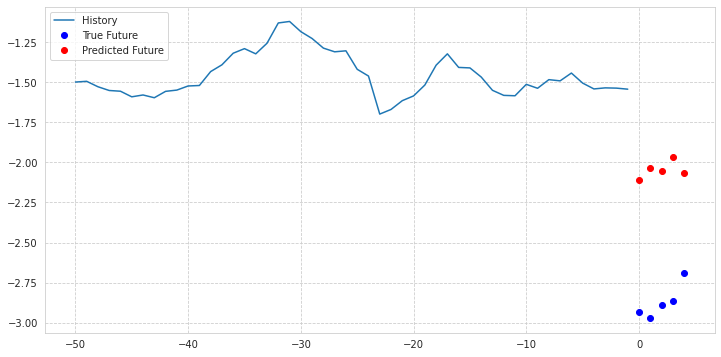

(50, 3) 5


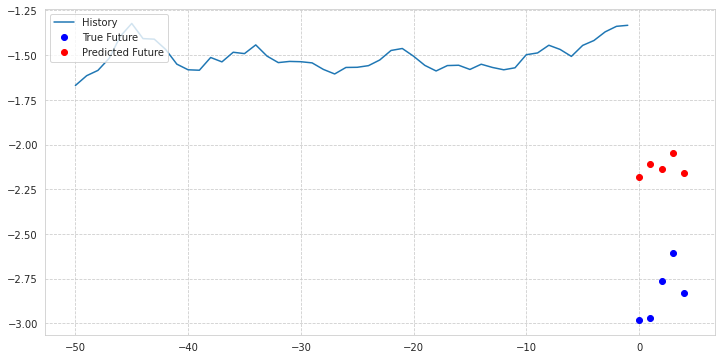

(50, 3) 5


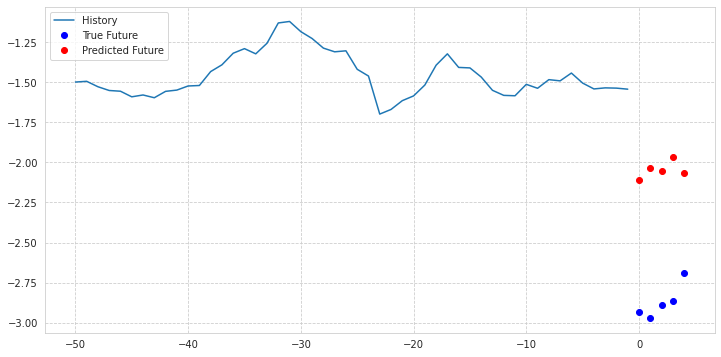

(50, 3) 5


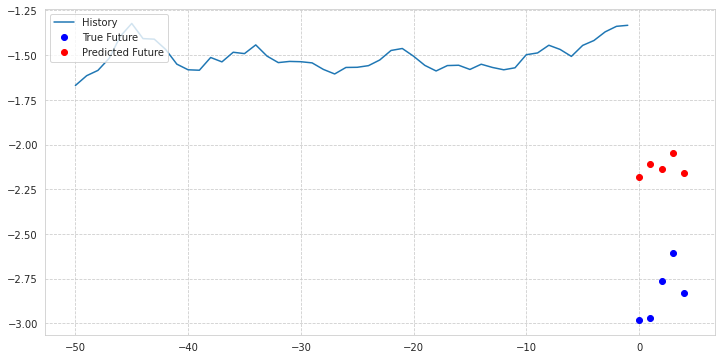

In [19]:
samples = 4
y_known = np.zeros((n_prediction, samples))
y_predict = np.zeros((n_prediction, samples))
count = 0

for x, y in validation_data.take(samples):
    print(x[-1].shape, lstm_model.predict(x)[0].shape[0])
    y_known[:, count] = y[0]
    y_predict[:, count] = lstm_model.predict(x)[0]
    multi_step_plot(x[-1], y[-1], lstm_model.predict(x, steps=5)[-1])
    count += 1

### 4.2 - Prediction Slope 

Another interesting thing to check is wether the slope of the prediction in general is the same orientation of the real one. Even if the general prediction is not perfectly accurate, estimating if a series of stock will increase or decrease is quintessential. 

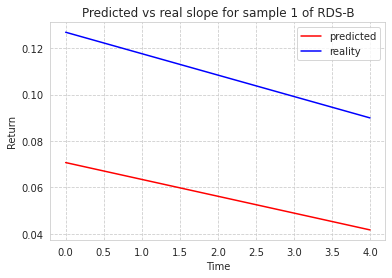

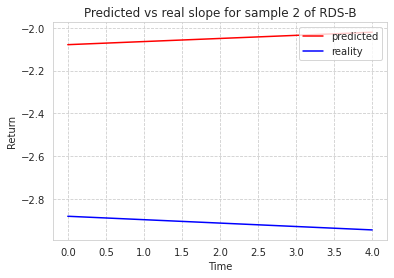

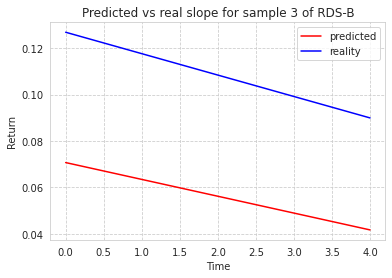

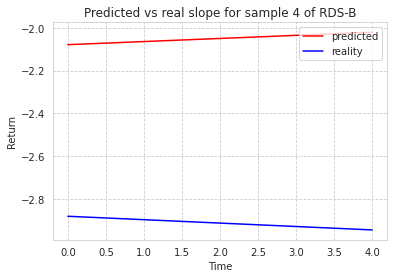

In [20]:
x_axis = np.arange(0, n_prediction)

for i in range(samples):

    # Create linear regression object
    regr_pred = linear_model.LinearRegression()
    regr_real = linear_model.LinearRegression()

    # Train the model using the training sets
    regr_pred.fit(x_axis.reshape(-1, 1), y_predict[:, i].reshape(-1, 1))
    regr_real.fit(x_axis.reshape(-1, 1), y_known[:, i].reshape(-1, 1))

    b0_pred = regr_pred.intercept_
    b0_real = regr_real.intercept_
    b1_pred = regr_pred.coef_
    b1_real = regr_real.coef_

    b0_error = abs(b0_pred - b0_real)
    b1_error = abs(b1_pred - b1_real)

    plt.figure(i)
    plt.title(f"Predicted vs real slope for sample {i+1} of {company_name}")
    plt.plot(x_axis, (b0_pred + b1_pred*x_axis).T, label="predicted", color="r")
    plt.plot(x_axis, (b0_real + b1_real*x_axis).T, label="reality", color="b")
    if b1_real > 0:
        plt.legend(loc='upper left')
    else:
        plt.legend(loc='upper right')
    plt.xlabel("Time")
    plt.ylabel("Return")
    
plt.show()